# Исследование объявлений о продаже квартир.

## Описание проекта.

Входные данные - архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 

#### Цели проектной работы:
Научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

## Содержание:

* [1. Знакомство с данными.](#first_bullet)
* [2. Предобработка данных.](#second_bullet)
    * [2.1 Работа с пропущенными значениями.](#third_bullet)
    * [2.2 Приведение данных к нужным типам.](#fourth_bullet)
* [3. Добавление параметров в таблицу.](#fifth_bullet)
* [4. Исследовательский анализ данных.](#sixth_bullet)
   * [4.1 Изучение параметров: площадь, цена, число комнат, высота потолков.](#seventh_bullet)
   * [4.2 Изучение время продажи квартиры.](#eighth_bullet)
   * [4.3 Удаление редких и выбивающихся значений.](#ninth_bullet)
   * [4.4 Выявление факторов, влияющих на стоимость.](#tenth_bullet)
   * [4.5 Топ населенных пунктов с наибольшим числом объявлений.](#eleventh_bullet)
   * [4.6 Выявление центральной области по цене недвижимости.](#twelfth_bullet)
   * [4.7 Анализ квартир, находящихся в центре.](#thirteenth_bullet)
* [5. Общий вывод.](#fourteenth_bullet)

## 1. Знакомство с данными. <a id="first_bullet"></a>

In [342]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.gridspec as gridspec

In [343]:
ad_archive = pd.read_csv('datasets/real_estate_data.csv', sep='\t')
print(ad_archive.shape)
print()
print(ad_archive.info())
print()
print(ad_archive.isnull().sum())

(23699, 22)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airpor

In [344]:
ad_archive.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1          11.0      2.0   посёлок Шушары           12817.0   
2           8.3      0.0  Санкт-Петербург           21741.0   
3           NaN      0.0  Санкт-Петербург           28098.0   
4          41.0      NaN  Санкт-Петербург           31856.0   

  cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.0               1.0          482.0               2.0   
1             18603.0               0.0            NaN               0.0   
2             13933.0               1.0           90.0               2.0   
3              6800.0               2.0           84.0               3.0   
4              8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0  

[5 rows x 22 columns]

## Вывод

Считали файл и посмотрели общую информацию. На вход мы получили архив объявлений, состоящий из 23699 строк и 22 столбца. В 14 столбцах имеются пропущенные значения. Важно отметить, что многие значения имеют тип данных float и object, что не во всех случаях уместно, исправим это ниже.

## 2. Предобработка данных. <a id="second_bullet"></a>

## 2.1. Работа с пропущенными значениями. <a id="third_bullet"></a>

Поработаем с пропусками в столбцах, которые нам понадобятся для анализа.

#### living_area

Поработаем с пропусками в living_area, в этом поле 1903 пропущенных значений. Мы не можем просто заполнить их средним или медианой, так как разброс площади квартир очень большой. Логично, что жилая площадь будет зависеть от общей площади квартиры. Проверим данную корреляцию. Сгруппируем квартиры с шагом в 10 метров в total_area и посчитаем среднее значение жилой площади для каждой группы. Методом transform заполним пустоты в living_area.

In [345]:
without_nan_in_living_area = ad_archive[~ad_archive['living_area'].isnull()]

In [346]:
#Проверим корреляцию общей от жилой площади, применим коэффициент Пирсона
print('Корреляция:',without_nan_in_living_area['total_area'].\
    corr(without_nan_in_living_area['living_area']))

Корреляция: 0.9395373338721501


In [347]:
#добавим столбец с разбивкой по 10 метров в total_area
ad_archive['total_area_group'] = ad_archive['total_area'] - ad_archive['total_area'] % 10

#так как к-во квартир свыше 400 метров очень маленькое, объеденим их в одну группу
ad_archive.loc[ad_archive[ad_archive['total_area_group'] > 400]['total_area_group'].index, 'total_area_group'] = 400

#заполним пустоты в living_area
ad_archive['living_area'] = ad_archive['living_area'].fillna(ad_archive.groupby('total_area_group')['living_area'].transform('mean'))

#проверим к-во nan в поле living_area
print('Количество Nan в living_area:', ad_archive.living_area.isnull().sum())

Количество Nan в living_area: 0


#### ponds_around3000, parks_around3000, balcony

Пропущенные значения в полях **ponds_around3000**, **parks_around3000**, **balcony** могут быть обусловлены отсутствием водоемов и парков в радиусе 3 км, а также балконов. По этой логике заменим пропущенные значения на 0.

In [348]:
#Заменим пропуски нолями
ad_archive['ponds_around3000'] = ad_archive['ponds_around3000'].fillna(0)
ad_archive['parks_around3000'] = ad_archive['parks_around3000'].fillna(0)
ad_archive['balcony'] = ad_archive['balcony'].fillna(0)

#### ceiling_height

Проверим данные в поле ceiling_height, чтобы понять, как лучше заменить пропущенные значения.

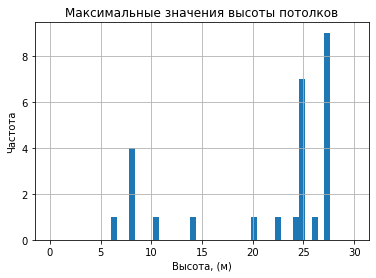

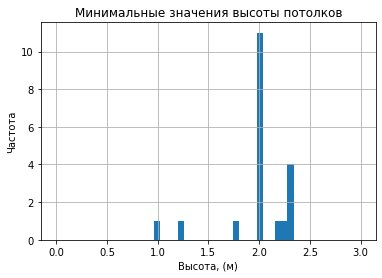

In [349]:
#Построим гистограммы частот по минимальным и максимальным значениям высоты потолков
ad_archive.ceiling_height.sort_values(ascending=False).head(30).hist(bins=50, range= (0,30))
plt.title("Максимальные значения высоты потолков")
plt.xlabel("Высота, (м)")
plt.ylabel("Частота")
plt.show()
ad_archive.ceiling_height.sort_values(ascending=True).head(20).hist(bins=50, range= (0,3))
plt.title("Минимальные значения высоты потолков")
plt.xlabel("Высота, (м)")
plt.ylabel("Частота")
plt.show()

Кажется, что все значения с высотой потолков выше 10 метров и меньше 2 являются некорректными, и могут быть следствием ошибки при выгрузке данных. Так как % таких квартир очень мал, удалим данные строки.

In [350]:
ad_archive = ad_archive.drop(ad_archive[(ad_archive['ceiling_height'] >= 10) | (ad_archive['ceiling_height'] <= 2)].index)

Высота потолков может, хоть и далеко не всегда, зависеть от площади квартиры или стоимости квартиры. Проверим, есть ли такая зависимость.

In [351]:
without_nan_in_ceiling_height = ad_archive[~ad_archive['ceiling_height'].isnull()]
print('Корреляция с общей площадью', \
      without_nan_in_ceiling_height['ceiling_height'].corr(without_nan_in_ceiling_height['total_area']))
print('Корреляция с жилой площадью', \
      without_nan_in_ceiling_height['ceiling_height'].corr(without_nan_in_ceiling_height['living_area']))   
print('Корреляция с ценой',\
      without_nan_in_ceiling_height['ceiling_height'].corr(without_nan_in_ceiling_height['last_price']))

Корреляция с общей площадью 0.45826485502043107
Корреляция с жилой площадью 0.4329245281006299
Корреляция с ценой 0.37943960443309394


Из данных видно, что есть умеренная корреляция c общей площадью недвижимости. Используем уже имеющееся поле 'total_area_group' для заполнения пропусков. Подставим медианное значения пустоты ceiling_height в зависимости от площади помещений.

In [352]:
#заполним пустоты в ceiling_height
ad_archive['ceiling_height'] \
    = ad_archive['ceiling_height'].fillna(ad_archive.groupby('total_area_group')['ceiling_height'].transform('median'))

#проверим к-во nan в поле ceiling_height
print('Количество Nan в ceiling_height:', ad_archive.ceiling_height.isnull().sum())

Количество Nan в ceiling_height: 0


#### kitchen_area

Взглянем на пустоты в kitchen_area. Наверное, некоторые nan могут быть обусловлены тем, что квартира является студией и в ней нет отдельно выделенной кухни. Проверим наличие студий, сгруппировав по полю studio.

In [353]:
ad_archive[ad_archive['kitchen_area'].isnull()].groupby('studio')['studio'].count()

studio
False    2122
True      149
Name: studio, dtype: int64

В квартирах-студиях заменим отсутствующие значения на 0.

In [354]:
#Определим индексы студий со значениями Nan
nan_studio_ind = ad_archive[ad_archive['kitchen_area'].isnull() & ad_archive['studio'] == True]['kitchen_area'].index
#Заменим на ноли площадь кухонь в этих строках
ad_archive.loc[nan_studio_ind, 'kitchen_area'] = ad_archive.loc[nan_studio_ind, 'kitchen_area'].fillna(0)

Оставшиеся значения заменим медианным значением в зависимости от группы по общей площади. Предарительно посмотрим корреляцию kitchen_area от total_area.

In [355]:
without_nan_in_kitchen_area = ad_archive[~ad_archive['kitchen_area'].isnull()]
print('Корреляция:',without_nan_in_kitchen_area['kitchen_area'].corr(without_nan_in_ceiling_height['total_area']))

Корреляция: 0.614612215248783


In [356]:
ad_archive['kitchen_area'] \
    = ad_archive['kitchen_area'].fillna(ad_archive.groupby('total_area_group')['kitchen_area'].transform('median'))
#проверим к-во nan в поле ceiling_height
print('Количество Nan в kitchen_area:', ad_archive.kitchen_area.isnull().sum())

Количество Nan в kitchen_area: 0


Некоторые поля не будут нам нужны для анализа, удалим их из выборки.

In [357]:
ad_archive.drop(['total_images', 'open_plan', 'is_apartment', 'ponds_around3000', \
                 'parks_around3000', 'balcony', 'parks_nearest', 'ponds_nearest', 'airports_nearest'], axis='columns', inplace=True)

#### locality_name

В ходе анализа мы будем работать с полем locality_name.  
Так как данные в нем заполнены по-разному, но значат одно и тоже (например, "посёлок Мурино" и "Мурино"), обработаем данные в этом поле для более корректной группировки в дальнейшем.


In [358]:
#Проверим количество уникальных значеий на входе
ad_archive['locality_name'].nunique()

363

In [359]:
#Заменим ё на е и посмотрим, как уменьшилось к-во уникальных значений
ad_archive['locality_name'] = ad_archive['locality_name'].replace('ё','е', regex=True)
ad_archive['locality_name'].nunique()

329

In [360]:
ad_archive.groupby('locality_name')['locality_name'].count().sort_values(ascending=False).head(10)

locality_name
Санкт-Петербург      15702
поселок Мурино         554
поселок Шушары         440
Всеволожск             397
Пушкин                 369
Колпино                338
поселок Парголово      327
Гатчина                306
деревня Кудрово        299
Выборг                 235
Name: locality_name, dtype: int64

In [361]:
#Приведем к одинаковому значению по-разному написанные населенные пункты
ad_archive.loc[ad_archive[ad_archive['locality_name'] == 'Мурино'].index, 'locality_name'] = 'поселок Мурино'
ad_archive.loc[ad_archive[ad_archive['locality_name'] == 'Кудрово'].index, 'locality_name'] = 'деревня Кудрово'
ad_archive.groupby('locality_name')['locality_name'].count().sort_values(ascending=False).head(10)

locality_name
Санкт-Петербург      15702
поселок Мурино         588
деревня Кудрово        471
поселок Шушары         440
Всеволожск             397
Пушкин                 369
Колпино                338
поселок Парголово      327
Гатчина                306
Выборг                 235
Name: locality_name, dtype: int64

Также в locality_name имеется с названием "nan", а также несколько пустых значений, удалим их из выборки.

In [362]:
#удалим строки с названием 'nan' в locality_name
ad_archive = ad_archive[ad_archive['locality_name'] != 'nan']
#удалим строки с пустым значением в locality_name
ad_archive = ad_archive[ad_archive['locality_name'].notna()]

#### floors_total

Удалим строки где не указано к-во этажей тотал.

In [363]:
ad_archive = ad_archive[ad_archive['floors_total'].notna()]

In [364]:
ad_archive.isnull().sum()

last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
studio                     0
kitchen_area               0
locality_name              0
cityCenters_nearest     5483
days_exposition         3162
total_area_group           0
dtype: int64

Посмотрим какие населенные пункты отсутствуют в cityCenters_nearest, соберем их в список для дальнейшей передачи коллегам, формирующим выгрузку

In [365]:
bag_report_list = ad_archive[ad_archive['cityCenters_nearest'].isnull()]['locality_name'].unique()

## 2.2. Приведение данных к нужным типам. <a id="fourth_bullet"></a>

Некоторы поля можно приводить в целочисленный тип данных, например floors_total, так как не может быть дробного числа этажей.
Поле first_day_exposition имеет тип object, заменим его на datetime.

In [366]:
ad_archive['floors_total'] = ad_archive['floors_total'].astype('int')
ad_archive['first_day_exposition'] = pd.to_datetime(ad_archive['first_day_exposition'])

## Вывод


Была подтверждена зависимость total_area и living_area. Пропуски заполнены медианным значением в зависимости от общей площади квартир.
Также мы заменили пустоты в ceiling_height характерными значениями, в зависимости от общей площади.
Также произвели замену дублей в locality_name для дальнейшей более корректной группировки, и удалили пустые значения.

В нашей выборке осталось 2 поля с незаполненными данными:
* cityCenters_nearest
* days_exposition

В поле cityCenters_nearest мы имеем пустые значения у населенных пунктов вне Санкт-Петербурга. Возможно, имеется нарушение работы в автоматичесом заполнении на основе картографических данных.

Также отсутствует часть данных в days_exposition - к сожалению, мы не можем подобрать подходящие значения для замены, поэтому оставим пустоты незаполненными.

В случаях необходимости анализа по параметрам days_exposition и cityCenters_nearest отфильтруем строки без пустот.

В полях floors_total и first_day_exposition типы данных были изменены на подходящие.

## 3. Добавление параметров в таблицу. <a id="fifth_bullet"></a>

In [367]:
# добавим поле, отвечающее за стоимость одного квадратного метра
ad_archive['cost_per_square_meter'] = ad_archive['last_price']/ad_archive['total_area']

# добавим день недели, месяц и год публикации объявления
ad_archive['week_day_exposition'] = ad_archive['first_day_exposition'].dt.weekday
ad_archive['month_exposition'] = ad_archive['first_day_exposition'].dt.month
ad_archive['year_exposition'] = ad_archive['first_day_exposition'].dt.year

Для добавления параметра этаж квартиры, напишем функцию

In [368]:
def floor_category(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return "Первый"
    elif floor == floors_total:
        return "Последний"
    else:
        return "Другой"
    
#добавим поле в датасет
ad_archive['floor_category'] = ad_archive.apply(floor_category, axis=1)

In [369]:
#добавим соотношение жилой и общей площади
ad_archive['living_and_total_area_ratio'] = ad_archive['living_area'] / ad_archive['total_area']
#добавим соотношение площади кухни и общей площади
ad_archive['kitchen_and_total_area_ratio'] = ad_archive['kitchen_area'] / ad_archive['total_area']

In [370]:
#переведем все цены и признаки площадей в целочисленный тип данных
ad_archive.last_price = ad_archive.last_price.astype(int)
ad_archive.total_area = ad_archive.total_area.astype(int)
ad_archive.living_area = ad_archive.living_area.astype(int)
ad_archive.kitchen_area = ad_archive.kitchen_area.astype(int)
ad_archive.cost_per_square_meter = ad_archive.cost_per_square_meter.astype(int)

## Вывод

В таблицу были добавлены параметры:
* cost_per_square_meter - цена квадратного метра;  
* week_day_exposition, month_exposition, year_exposition - день, месяц, год публикации соответственно;  
* floor_category - категория этажей;
* living_and_total_area_ratio, kitchen_and_total_area_ratio - соотношения площадей.

Также все признаки площадей и обе цены были приведены к целочисленному типу данных

## 4. Исследовательский анализ данных. <a id="sixth_bullet"></a>

## 4.1. Построим гистограммы для столбцов: площадь, цена, число комнат, высота потолков. <a id="seventh_bullet"></a>

Медиана площади недвижимости: 52
Медиана стоимости недвижимости: 4650000
Cредняя высота потолков: 2.7
Cреднее число комнат: 2


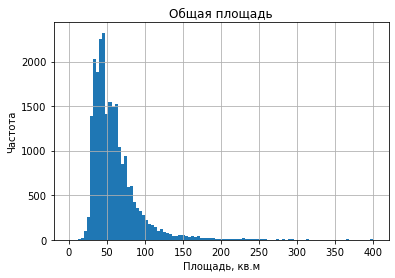

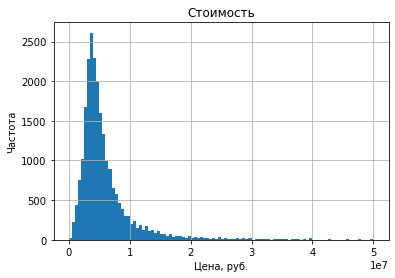

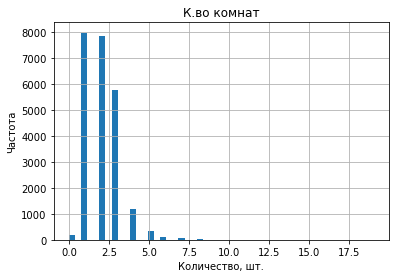

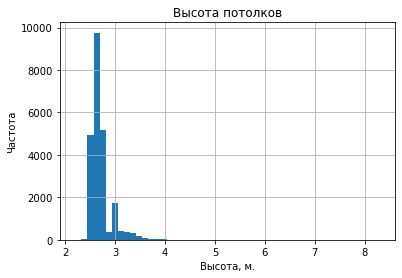

In [371]:
#Посмотрим средние показатели по параметрам, для стоимости и площади возьмем медианы
print('Медиана площади недвижимости:', round(ad_archive['total_area'].median()))
print('Медиана стоимости недвижимости:', round(ad_archive['last_price'].median()))
print('Cредняя высота потолков:', round(ad_archive['ceiling_height'].mean(),1))
print('Cреднее число комнат:', round(ad_archive['rooms'].mean()))

ad_archive.hist(column='total_area', bins=100, range=(0,400))
plt.title("Общая площадь")
plt.xlabel("Площадь, кв.м")
plt.ylabel("Частота")
plt.show()
ad_archive.hist(column='last_price', bins=100, range=(12190,50000000))
plt.title("Стоимость")
plt.xlabel("Цена, руб.")
plt.ylabel("Частота")
plt.show()
ad_archive.hist(column='rooms', bins=50)
plt.title("К.во комнат")
plt.xlabel("Количество, шт.")
plt.ylabel("Частота")
plt.show()
ad_archive.hist(column='ceiling_height', bins=50)
plt.title("Высота потолков")
plt.xlabel("Высота, м.")
plt.ylabel("Частота")
plt.show()

## Вывод

Построены гистограммы по следующим параметрам: площадь, цена, число комнат, высота потолков.

Как видно из графиков, больше всего продаются небольшие квартиры - одно- и двухкомнатные с площадью около 50 кв.м.
Это связано с тем, что квартиры такой площади в больших городах являются оптимальным решением при покупке, в первую очередь из-за стоимости, соответственно и продаваться они будут в большем количестве. 

Самая распространенная стоимость - от 4 до 5 млн. рублей, ну а высота потолков стандартная - 2,7 метра.

## 4.2. Изучение время продажи квартиры. <a id="eighth_bullet"></a>

Так как мы не можем корректно произвести замену в поле days_exposition, для анализа данного параметра отберем только значения без nan.  
Приведем значения поля к целочисленному типу, так как days_exposition измеряется в днях.

In [372]:
days_exposition_new = ad_archive[~ad_archive['days_exposition'].isnull()]['days_exposition'].astype('int').to_frame() 

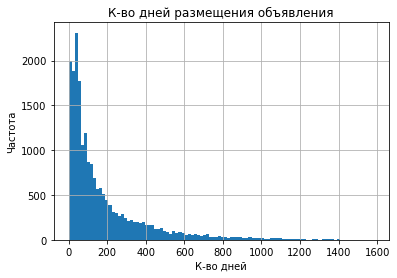

In [373]:
days_exposition_new.hist(bins=100)
plt.title("К-во дней размещения объявления")
plt.xlabel("К-во дней")
plt.ylabel("Частота")
plt.show()

In [374]:
days_exposition_new.describe()

days_exposition
count     20364.000000
mean        180.815508
std         219.824084
min           1.000000
25%          45.000000
50%          95.000000
75%         231.000000
max        1580.000000

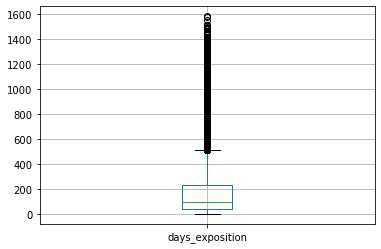

In [375]:
days_exposition_new.boxplot()
plt.show()

## Вывод

Применив метод describe, мы видим, насколько отличается среднее значение от медианы. Это обусловлено большим хвостом выборки, который перетягивает на себя среднее. 

Четверть квартир были проданы за 1,5 месяца, половина за 95 дней, и большая часть в течение года.

**За быстрые продажи можно считать те, что произошли до 45 дней - 25% выборки,
а долгие продажи все, что больше 231 дня - свыше 75% выборки.**

Всё, что лежит за пределами верхнего уса ящика (1,5 межквартильных размаха), можем считать выбрасами.  
Таким образом, всё, что выходит за границу 510 дней - довольно большой срок продажи и скорее редкость.

## 4.3. Удаление редких и выбивающихся значений. <a id="ninth_bullet"></a>

Поработаем с аномальными значениями, которые не были выявлены в процессе предобработки данных.

#### last_price

Начнем с поля last_price - сделаем срез наименьших и наибольших значений цены недвижимости.

In [376]:
print(ad_archive.sort_values(by='last_price')['last_price'].head())
print(ad_archive.sort_values(by='last_price')['last_price'].tail())
print()
print(ad_archive.loc[8793])

8793      12190
17456    430000
14911    430000
16274    440000
17676    450000
Name: last_price, dtype: int64
15651    300000000
1436     330000000
14706    401300000
19540    420000000
12971    763000000
Name: last_price, dtype: int64

last_price                                    12190
total_area                                      109
first_day_exposition            2019-03-20 00:00:00
rooms                                             2
ceiling_height                                 2.75
floors_total                                     25
living_area                                      32
floor                                            25
studio                                        False
kitchen_area                                     40
locality_name                       Санкт-Петербург
cityCenters_nearest                            9176
days_exposition                                   8
total_area_group                                100
cost_per_square_meter             

Наверное, 763 млн. рублей могут быть близостью к центру, большой площадью, может, даже это квартира, которая пренадлежала очень известному человеку. Но вот жильё в 109 м, которое стоит 12190 рублей, явно выглядит как ошибка. Удалим данную строку.

In [377]:
ad_archive = ad_archive.query("index != 8793")

#### rooms

Посмотрим, как обстоят дела с количеством комнат, для начала получим уникальные значения.

In [378]:
print('Уникальные значения количества комнат', ad_archive['rooms'].unique())
print('Количество квартир с нулевым значением комнат', ad_archive[ad_archive['rooms'] == 0]['rooms'].count())
#удалим нулевые значения
ad_archive = ad_archive.drop(ad_archive[ad_archive['rooms'] == 0].index)

Уникальные значения количества комнат [ 3  1  2  4  5  6  0  7 11  8 14 10 15  9 19 16 12]
Количество квартир с нулевым значением комнат 193


Нули в количестве комнат - это ошибка. Она может быть обусловена ошибкой выгрузки или необязательностью указания данного параметра в объявлении. 193 - это меньше одного процента от выбоки, удалим данные значения, чтобы они не искажали наши дальнейшие выводы.

#### floors_total

In [379]:
print(ad_archive['floors_total'].sort_values().tail())
ad_archive = ad_archive.drop([16731,2253])

22946    35
11079    36
397      36
16731    52
2253     60
Name: floors_total, dtype: int64


Один запрос поисковику поможет узнать, что жилых помещений выше 40 этажей в Санкт-Петербурге нет. Удалим аномальные 52 и 60 этажные здания.

## Вывод

После проверки полей с количественными переменными были удалены аномальные значения, которые могут быть обусловлены ошибкой выгрузки данных или особенностью их логирования. Решение об удалении было принято исходя из небольшого количества удаляемых данных, во избежание искажения дальнейших выводов.

Так, например, мы удалили строку с аномально низкой ценой - 12190 рубля за 109 кв.м, 193 строки с нулевым значением к-ва комнат, квартиры в нереалистично многоэтажных домах для Санкт-Петербурга домах - 56 и 60 этажей.

Посмотрим распределения по всем признакам площадей, цене, потолкам и комнатам.

In [380]:
def iqr(df, column):
    """
    Функция подсчитывает диапазон с учетом межквартильного размаха
    """
    print(df[column].describe())
    iqr = df[column].describe()[6] - df[column].describe()[4]
    low_bond = df[column].describe()[4] - 1.5 * iqr
    if low_bond < 0:
        low_bond = df[column].describe()[3]
    upper_bond = df[column].describe()[6] + 1.5 * iqr
    print('Нижняя граница:', low_bond)
    print('Верхняя граница:', upper_bond)

iqr(ad_archive, 'total_area')

count    23330.000000
mean        60.366524
std         35.645631
min         12.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64
Нижняя граница: 12.0
Верхняя граница: 115.0


In [381]:
fig = px.histogram(ad_archive, x = 'kitchen_area', marginal = 'box', title = 'Распределение kitchen_area')
fig.show()
iqr(ad_archive, 'kitchen_area')
fig = px.histogram(ad_archive, x = 'living_area', marginal = 'box', title = 'Распределение living_area')
fig.show()
iqr(ad_archive, 'living_area')
fig = px.histogram(ad_archive, x = 'last_price', marginal = 'box', title = 'Распределение last_price')
fig.show()
iqr(ad_archive, 'last_price')
fig = px.histogram(ad_archive, x = 'ceiling_height', marginal = 'box', title = 'Распределение ceiling_height')
fig.show()
iqr(ad_archive, 'ceiling_height')
fig = px.histogram(ad_archive, x = 'rooms', marginal = 'box', title = 'Распределение rooms')
fig.show()
iqr(ad_archive, 'rooms')
fig = px.histogram(ad_archive, x = 'cost_per_square_meter', marginal = 'box', title = 'Распределение по стоимости за квадрат')
fig.show()
iqr(ad_archive, 'cost_per_square_meter')

count    23330.000000
mean        10.220103
std          5.773070
min          0.000000
25%          7.000000
50%          9.000000
75%         11.000000
max        112.000000
Name: kitchen_area, dtype: float64
Нижняя граница: 1.0
Верхняя граница: 17.0


count    23330.000000
mean        34.486027
std         22.424392
min          2.000000
25%         18.000000
50%         30.000000
75%         42.000000
max        409.000000
Name: living_area, dtype: float64
Нижняя граница: 2.0
Верхняя граница: 78.0


count    2.333000e+04
mean     6.570584e+06
std      1.095100e+07
min      4.300000e+05
25%      3.450000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64
Нижняя граница: 430000.0
Верхняя граница: 11825000.0


count    23330.000000
mean         2.701534
std          0.243799
min          2.200000
25%          2.600000
50%          2.600000
75%          2.750000
max          8.300000
Name: ceiling_height, dtype: float64
Нижняя граница: 2.375
Верхняя граница: 2.9749999999999996


count    23330.000000
mean         2.088255
std          1.066748
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64
Нижняя граница: 1.0
Верхняя граница: 6.0


count    2.333000e+04
mean     9.934539e+04
std      5.043706e+04
min      7.962000e+03
25%      7.650850e+04
50%      9.490000e+04
75%      1.140665e+05
max      1.907500e+06
Name: cost_per_square_meter, dtype: float64
Нижняя граница: 20171.5
Верхняя граница: 170403.5


Посмотрев логически оценим выбросы, удалим их из нашей выборки.

In [382]:
abnormal_values = ad_archive.query('total_area > 300            | total_area < 12       |\
                                 ceiling_height  > 5            | ceiling_height < 2.4 |\
                                 rooms > 14                     | rooms < 1             |\
                                 last_price > 160000000         | last_price < 430000   |\
                                 cost_per_square_meter > 400000').index

In [383]:
print('Количество аномальных значений:', len(abnormal_values))
ad_archive.drop(abnormal_values, inplace=True)

Количество аномальных значений: 141


Также похожи на аномальные те значения, где отношение жилой площади к общей очень маленькое

In [384]:
fig = px.histogram(ad_archive, x = 'living_and_total_area_ratio', \
                   marginal = 'box', title = 'Распределение last_price')
fig.show()

In [385]:
ad_archive.drop(ad_archive.query('living_area + kitchen_area > total_area').index, inplace=True)

Также те случаи, где сумма площади кухни и жилой площади превышает общую, удалим их

In [386]:
ad_archive.drop(ad_archive.\
                query('living_and_total_area_ratio < 0.34').index, inplace=True)

In [387]:
ad_archive.describe()

last_price    total_area         rooms  ceiling_height  floors_total  \
count  2.273000e+04  22730.000000  22730.000000    22730.000000  22730.000000   
mean   6.057445e+06     59.164364      2.083678        2.695546     10.594501   
std    5.477080e+06     29.747879      1.026827        0.222219      6.530089   
min    4.300000e+05     12.000000      1.000000        2.400000      1.000000   
25%    3.450000e+06     40.000000      1.000000        2.600000      5.000000   
50%    4.626540e+06     52.000000      2.000000        2.600000      9.000000   
75%    6.700000e+06     69.000000      3.000000        2.750000     15.000000   
max    9.900000e+07    300.000000     14.000000        5.000000     36.000000   

        living_area         floor  kitchen_area  cityCenters_nearest  \
count  22730.000000  22730.000000  22730.000000          17427.00000   
mean      34.060845      5.832292      9.917202          14278.18018   
std       19.538832      4.831649      4.987150           8634.25596   
min        8.000000      1.000000      0.000000            181.00000   
25%       19.000000      2.000000      7.000000           9415.50000   
50%       30.000000      4.000000      9.000000          13138.00000   
75%       42.000000      8.000000     11.000000          16299.50000   
max      250.000000     33.000000    100.000000          65968.00000   

       days_exposition  total_area_group  cost_per_square_meter  \
count     19668.000000      22730.000000           22730.000000   
mean        180.968883         55.025517           97192.659349   
std         220.068926         29.830084           38252.927426   
min           1.000000         10.000000            7962.000000   
25%          45.000000         40.000000           76160.250000   
50%          95.000000         50.000000           94542.500000   
75%         231.000000         60.000000          113304.750000   
max        1580.000000        300.000000          400000.000000   

       week_day_exposition  month_exposition  year_exposition  \
count         22730.000000      22730.000000     22730.000000   
mean              2.567928          6.393269      2017.371227   
std               1.789799          3.492748         1.037160   
min               0.000000          1.000000      2014.000000   
25%               1.000000          3.000000      2017.000000   
50%               3.000000          6.000000      2017.000000   
75%               4.000000         10.000000      2018.000000   
max               6.000000         12.000000      2019.000000   

       living_and_total_area_ratio  kitchen_and_total_area_ratio  
count                 22730.000000                  22730.000000  
mean                      0.567840                      0.183481  
std                       0.094184                      0.065041  
min                       0.340000                      0.000000  
25%                       0.500000                      0.135196  
50%                       0.570158                      0.170213  
75%                       0.632690                      0.225806  
max                       0.988846                      0.625000

После проверки полей с количественными переменными были удалены аномальные значения, которые могут быть обусловлены ошибкой выгрузки данных или особенностью их логирования. Решение об удалении было принято исходя из небольшого количества удаляемых данных, во избежание искажения дальнейших выводов.

Так, например, мы удалили строку с аномально низкой ценой - 12190 рубля за 109 кв.м, 193 строки с нулевым значением к-ва комнат, квартиры в нереалистично многоэтажных домах для Санкт-Петербурга домах - 56 и 60 этажей.

Также были удалены аномальные значения которые сильно выбиваются из выборки:
* квартиры площадью свыше 300 кв.метров и меньше 12 кв.метров
* квартиры с высотой потолков выше 5 и ниже 2.4 метров
* квартиры с количесвом комнат больше 14
* ценой больше 160 млн. и меньше 430 тыс.
* и с ценой за квадратный метр больше 400 тыс

Также были удалены те случаи, где сумма площади кухни и жилой площади превышает общую

Также были удалены те где отношение жилой площади к общей очень маленькое - меньше 0.34</b>
</div>

## 4.4. Выявление факторов, влияющих на стоимость. <a id="tenth_bullet"></a>

Проанализируем, какие факторы больше всего влияют на стоимость квартиры. Посмтроим матрицу корреляции и зависимость цены от площади, числа комнат, удалённости от центра.

                       last_price  total_area     rooms  cityCenters_nearest  \
last_price               1.000000    0.786288  0.495903            -0.315935   
total_area               0.786288    1.000000  0.794541            -0.245318   
rooms                    0.495903    0.794541  1.000000            -0.184778   
cityCenters_nearest     -0.315935   -0.245318 -0.184778             1.000000   
cost_per_square_meter    0.707443    0.250324  0.009530            -0.382003   

                       cost_per_square_meter  
last_price                          0.707443  
total_area                          0.250324  
rooms                               0.009530  
cityCenters_nearest                -0.382003  
cost_per_square_meter               1.000000  


array([[<AxesSubplot:xlabel='last_price', ylabel='last_price'>,
        <AxesSubplot:xlabel='total_area', ylabel='last_price'>,
        <AxesSubplot:xlabel='rooms', ylabel='last_price'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='last_price'>,
        <AxesSubplot:xlabel='cost_per_square_meter', ylabel='last_price'>],
       [<AxesSubplot:xlabel='last_price', ylabel='total_area'>,
        <AxesSubplot:xlabel='total_area', ylabel='total_area'>,
        <AxesSubplot:xlabel='rooms', ylabel='total_area'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='total_area'>,
        <AxesSubplot:xlabel='cost_per_square_meter', ylabel='total_area'>],
       [<AxesSubplot:xlabel='last_price', ylabel='rooms'>,
        <AxesSubplot:xlabel='total_area', ylabel='rooms'>,
        <AxesSubplot:xlabel='rooms', ylabel='rooms'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='rooms'>,
        <AxesSubplot:xlabel='cost_per_square_meter', ylabel='rooms'>],
       [<AxesSubp

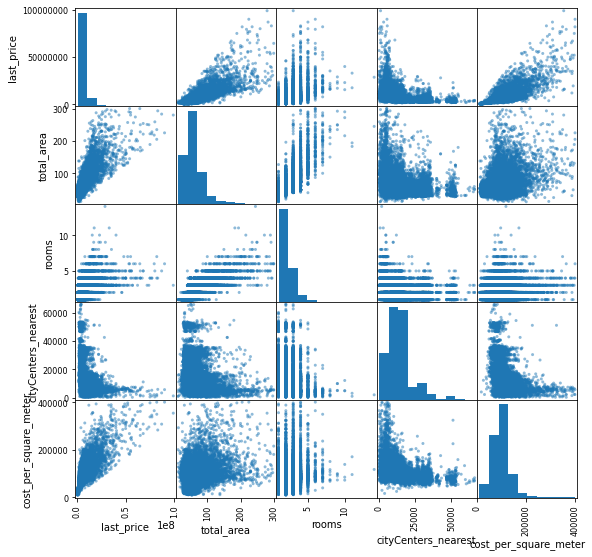

In [388]:
price_correlation = ad_archive[['last_price', 'total_area', 'rooms', 'cityCenters_nearest', 'cost_per_square_meter']]
print(price_correlation.corr())
pd.plotting.scatter_matrix(price_correlation, figsize=(9, 9))


Наиболее сильная зависимость стоимости жилья - от площади квартиры. Следом умеренная взаимосвязь есть от количества комнат. Логично, что количество комнат косвенно связано с площадью жилища, но в то же время не всегда большие квартиры должны иметь очень большое к-во комнат.

Ну и так же есть не очень ярко выраженная обратная зависимость стоимости от удаленности от центра. Возможно, что дорогие загородные дома вносят свою лепту.

Посмотрим на зависимость стоимости жилья от этажа, на котором располагается квартира.

floor_category
Первый       3900000
Последний    4300000
Другой       4850000
Name: last_price, dtype: int64


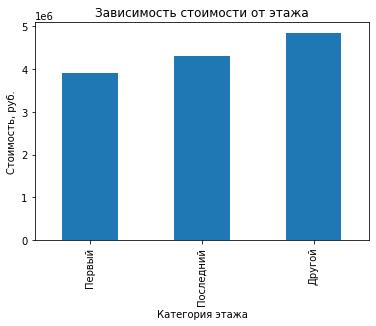

In [389]:
floor_category = ad_archive.groupby('floor_category')['last_price'].median().sort_values()
print(floor_category)
floor_category.plot(kind='bar', y='count')
plt.title("Зависимость стоимости от этажа")
plt.xlabel("Категория этажа")
plt.ylabel("Стоимость, руб.")
plt.show()

Первый и последний этаж ожидаемо дешевле, чем все остальные, это можно объяснить несколькими особенностями такого расположения квартир.   

Наиболее низкая цена первого этажа может объясняться следующими факторами:  
* Высокий уровень шума - разговоры на улице и в подъезде, хлопанье входной дверью;  
* Низкое расположение окон первого этажа - в них можно беспрепятственно заглянуть;  
* Отсутсвие защищённости ввиду с возможностью проникнуть в квартиру с улицы с целью кражи имущества (но это в случае, если никак не обеспечить защиту своего жилья).

Низкая цена последнего этажа в сравнении с остальными может объясняться:  
* Потенциальной протечкой крыши;  
* Зависимостью от лифта - его долгим ожиданием в "часы пик" или поломкой;  
* Сложностью с регулированием температуры в помещении за счет нагрева крыш в жаркий период в домах, где отсутствует технический этаже;  
* Возможными проблемами с вентиляцией - поступление в квартиру запахов с нижних этажей, возникновение обратной тяги в холодный период и т.д.


Посмотрим на зависимость цены от даты размещения: дня недели, месяца и года.  
Построим сводные таблицы и гистограммы для ранее созданных категорий - week_day_exposition, month_exposition, year_exposition

   week_day_exposition  last_price  count
0                    0     4648500   3474
1                    1     4704595   4012
2                    2     4700000   3812
3                    3     4600000   4109
4                    4     4580000   3840
5                    5     4550000   1852
6                    6     4550000   1631
    month_exposition  last_price  count
0                  1     4600000   1436
1                  2     4650000   2551
2                  3     4650000   2491
3                  4     4775000   2279
4                  5     4500000   1213
5                  6     4400000   1703
6                  7     4600000   1613
7                  8     4600000   1679
8                  9     4700000   1894
9                 10     4599000   2015
10                11     4700000   2282
11                12     4690000   1574
   year_exposition  last_price  count
0             2014     8037000    129
1             2015     5250000   1118
2             2016     4500000

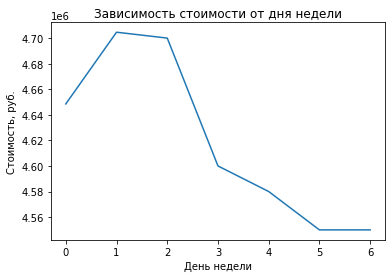

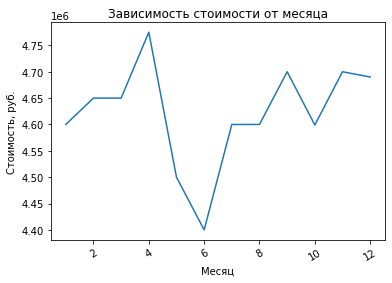

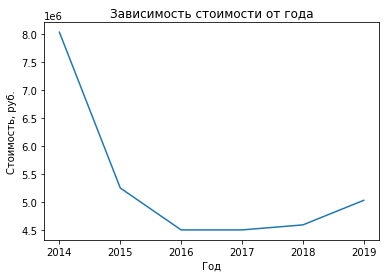

In [390]:
#Посстроим сводные таблицы
week_day_exposition = (ad_archive.
                   pivot_table(index='week_day_exposition', values='last_price', aggfunc=['median', 'count']).
                   reset_index())
month_exposition = (ad_archive.
                   pivot_table(index='month_exposition', values='last_price', aggfunc=['median', 'count']).
                   reset_index())
year_exposition = (ad_archive.
                   pivot_table(index='year_exposition', values='last_price', aggfunc=['median', 'count']).
                   reset_index())
week_day_exposition.columns = ['week_day_exposition', 'last_price', 'count']
month_exposition.columns = ['month_exposition', 'last_price', 'count']
year_exposition.columns = ['year_exposition', 'last_price', 'count']

#Выведем сводные 
print(week_day_exposition)
print(month_exposition)
print(year_exposition)

#Выведем гистограммы
# week_day_exposition.plot(x='week_day_exposition', y='last_price', kind='bar')
# plt.show()
# month_exposition.plot(x='month_exposition', y='last_price', kind='bar')
# plt.show()
# year_exposition.plot(x='year_exposition', y='last_price', kind='bar')
# plt.show()


sns.lineplot(data=week_day_exposition, x='week_day_exposition', y='last_price')
plt.title("Зависимость стоимости от дня недели")
plt.xlabel("День недели")
plt.ylabel("Стоимость, руб.")
plt.show()

plot = sns.lineplot(data=month_exposition, x='month_exposition', y='last_price')
plt.title("Зависимость стоимости от месяца")
plt.xlabel("Месяц")
plt.ylabel("Стоимость, руб.")
plt.setp(plot.get_xticklabels(), rotation=30)
plt.show()

sns.lineplot(data=year_exposition, x='year_exposition', y='last_price')
plt.title("Зависимость стоимости от года")
plt.xlabel("Год")
plt.ylabel("Стоимость, руб.")
plt.show()


Есть зависимость от дня недели - самая высокая цена в первой половине недели.

По месяцам - есть небольшое колебание цена, в частности, в мае и июне цены снижаются. Этo может быть вызвaнo тeм, чтo люди yeзжaют в oтпycкa, пpoвoдят мнoгo вpeмeни нa пpиpoдe и нe гoтoвы пoлнoцeннo пocвящaть ceбя paбoчим вoпpocaм. B cвязи co cнижeниeм cпpoca пpoдaвцы oпycкaют цeны нa cвoи oбъeкты.

Более ярко видна зависимость от года - спад стоимости в 2015 и 2016 году.
Возможно, она связана с небольшим к-вом объявлений за 2014 год в нашей выборке. Может, также сыграл и ввод санкций и падение курса рубля в 2014-2015 годах.

## Вывод

Больше всего стоимость квартиры зависит от её площади. Будь то центр города или пригород - люди, в первую очередь, платят за квадратные метры. Как следствие, имеется умеренная корреляция с количеством комнат, так как количество связано с площадью жилья. И самая слабая зависимость от удаленности от центра. 

Квартиры на первом и последнем этаже - более дешевые. Высокая проходимость и шум на первых этажах, а также нагрев помещения от крыши и потенциальное протекание осталвляют своё влияние на стоимости квартир на этих этажах.

Есть зависимость от дня недели - самая высокая цена в первой половине недели. Есть зависимость от месяца продажи - с наступлением тепла цены снижаются.

Ещё имеется зависимость от года размещения объявления - спад стоимости в 2015 и 2016 году. Основных гипотез 2 - маленькое к-во объявлений в выборке в сравнении с другими годами, а также падение рубля и введенные санкции, повлиявшие на экономику в целом и на рынок недвижимости в частности.

## 4.5. Топ населенных пунктов с наибольшим числом объявлений. <a id="eleventh_bullet"></a>

Построим рейтинг городов по количеству объявлений. Выявим населённые пункты с самой высокой и низкой стоимостью жилья.

In [391]:
#Сделаем необходимую нам агрегацию в своддной таблице
locality_name_top = ad_archive.pivot_table(index='locality_name', \
                                           values='cost_per_square_meter', \
                                           aggfunc=['count', 'mean', 'min', 'max'])
#переименуем поля
locality_name_top.columns = ['count', 'mean_price', 'min', 'max']

#отсортируем и выделим топ 10
locality_name_top = locality_name_top.sort_values(by='count', ascending=False).head(10)
locality_name_top.style.format({'mean_price': '{:.0f}',\
                                                       'min': '{:.0f}',
                                                       'max': '{:.0f}'})


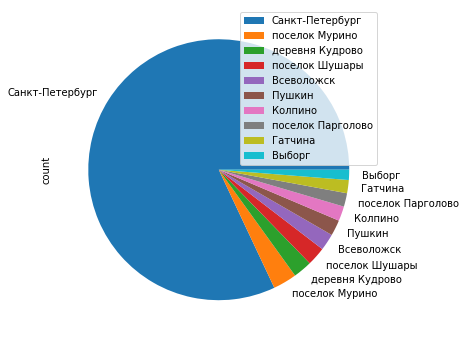

In [392]:
locality_name_top.plot(kind='pie',  y='count', figsize=(6,6))
plt.show()

In [393]:
print(locality_name_top.sort_values(by='max', ascending=False).head(3))
print(locality_name_top.sort_values(by='max', ascending=False).tail(3))

                 count     mean_price    min     max
locality_name                                       
Санкт-Петербург  15072  111852.569201  15861  400000
Пушкин             359  103074.172702  59836  256521
деревня Кудрово    429   95111.221445  54160  160401
                count    mean_price    min     max
locality_name                                     
поселок Шушары    425  78051.494118  47700  126666
Колпино           334  75491.431138  50819  125000
Выборг            232  58468.107759  18750  107473


## Вывод

Ожидаемо - наибольшее к-во объявлений у Санкт-Петербурга, как и максимальная стоимость за квадратный метр. Далее по максимальной стоимости с большим отрывом идут - Пушкин и Кудрово.

Самые недорогие квартиры в рейтинге наибольшего к-ва объявлений, находятся в Шушары, Колпино и Выборг.

## 4.6. Выявление центральной области по цене недвижимости.<a id="twelfth_bullet"></a>

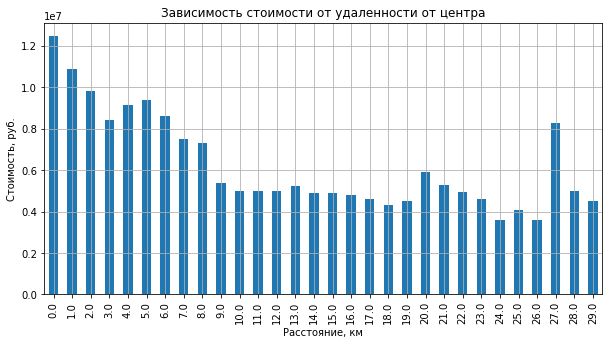

In [394]:
#Выберем объявления только по Питеру, уберем пропуски из cityCenters_nearest
Spb_data = ad_archive.query('locality_name == "Санкт-Петербург"')
Spb_data = Spb_data[~Spb_data['cityCenters_nearest'].isnull()]

#Сделаем столбец с расстоянием в километрах, округлим до целых
Spb_data['cityCenters_nearest_km'] = Spb_data['cityCenters_nearest'] / 1000
Spb_data['cityCenters_nearest_km'] = Spb_data['cityCenters_nearest_km'].round()

#посчитаем медианное значение стоимости для каждого километра
Spb_data_groupby = Spb_data.groupby('cityCenters_nearest_km')['last_price'].median()

#Построим график зависимости цены от удаленности от центра
Spb_data_groupby.plot(kind='bar', figsize=(10,5), grid=True)
plt.title("Зависимость стоимости от удаленности от центра")
plt.xlabel("Расстояние, км")
plt.ylabel("Стоимость, руб.")
plt.show()

## Вывод

Цена резко снижается на 9м километре, видимо, это и есть условная граница центра Санкт-Петербурга.

## 4.7. Анализ квартир находящихся в центре. <a id="thirteenth_bullet"></a> 

Проанализируем квартиры, находящиеся в центре, и сравним результаты с уже имеющимися по всем объявлениям.

Добавим категориальный признак принадлежнасти населенного пункта к центру, для этого напишем функцию:

In [395]:
def city_center(cityCenters_nearest_km):
    if cityCenters_nearest_km <= 8:
        return 'центр'
    else:
        return 'область за центром'

In [396]:
Spb_data['is_center'] = Spb_data['cityCenters_nearest_km'].apply(city_center)

Сравним центр с областью за центром по основным парметрам

In [397]:
Spb_data.groupby(['is_center'])\
    .aggregate({'total_area': 'median', 'cost_per_square_meter' : 'median', \
                 'ceiling_height': 'median', 'rooms': 'median'})

total_area  cost_per_square_meter  ceiling_height  rooms
is_center                                                                   
область за центром          50                 100961            2.60      2
центр                       75                 121285            2.95      3

Построим сравнение на графиках по основным параметрам.

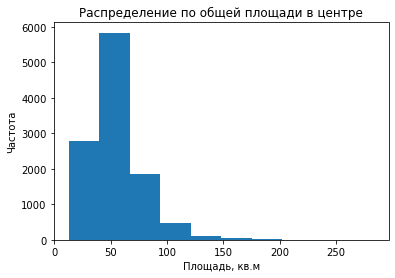

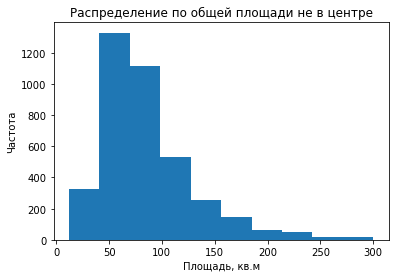

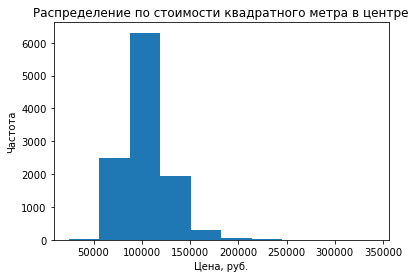

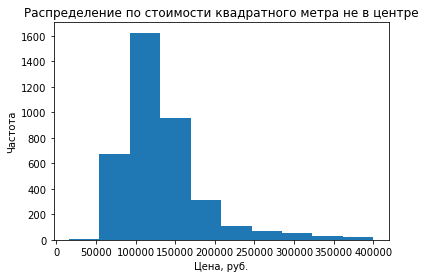

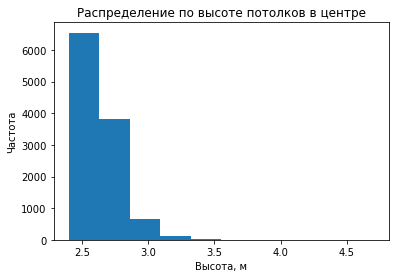

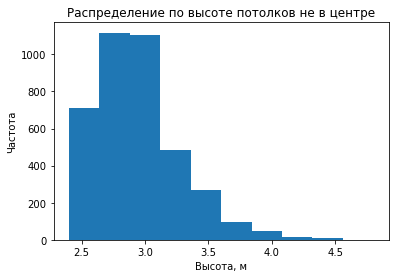

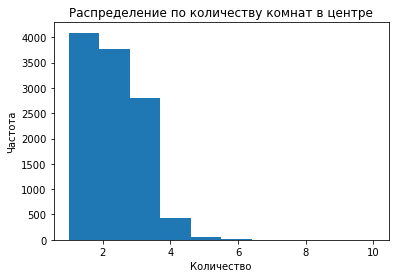

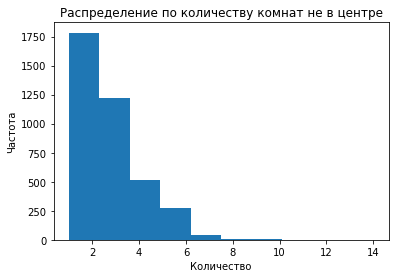

In [398]:
center_data = Spb_data[Spb_data['is_center'] == 'центр']
not_center_data = Spb_data[Spb_data['is_center'] == 'область за центром']

#распределение по площадям
not_center_data['total_area'].plot(kind='hist')
plt.title("Распределение по общей площади в центре")
plt.xlabel("Площадь, кв.м")
plt.ylabel("Частота")
plt.show()
center_data['total_area'].plot(kind='hist')
plt.title("Распределение по общей площади не в центре")
plt.xlabel("Площадь, кв.м")
plt.ylabel("Частота")
plt.show()

#распределение по стоимости квадратного метра
not_center_data['cost_per_square_meter'].plot(kind='hist')
plt.title("Распределение по стоимости квадратного метра в центре")
plt.xlabel("Цена, руб.")
plt.ylabel("Частота")
plt.show()
center_data['cost_per_square_meter'].plot(kind='hist')
plt.title("Распределение по стоимости квадратного метра не в центре")
plt.xlabel("Цена, руб.")
plt.ylabel("Частота")
plt.show()

#распределение по площадям
not_center_data['ceiling_height'].plot(kind='hist')
plt.title("Распределение по высоте потолков в центре")
plt.xlabel("Высота, м")
plt.ylabel("Частота")
plt.show()
center_data['ceiling_height'].plot(kind='hist')
plt.title("Распределение по высоте потолков не в центре")
plt.xlabel("Высота, м")
plt.ylabel("Частота")
plt.show()

#распределение по площадям
not_center_data['rooms'].plot(kind='hist')
plt.title("Распределение по количеству комнат в центре")
plt.xlabel("Количество")
plt.ylabel("Частота")
plt.show()
center_data['rooms'].plot(kind='hist')
plt.title("Распределение по количеству комнат не в центре")
plt.xlabel("Количество")
plt.ylabel("Частота")
plt.show()

Как видно, центр содержит более лучшие характеристики - более высокие потолки, более высокая стоимость и площадь недвижимости и количество комнат. Многое из этого характерно для старых домов Санкт-Петербурга.

In [399]:
price_correlation_center = center_data[['last_price', 'total_area',\
                                       'rooms', 'cityCenters_nearest', 'ceiling_height' ]]

print('Квартиры в центре')
print(price_correlation_center.corr())
print()
print('Вся выборка')
print(price_correlation.corr())                                  

Квартиры в центре
                     last_price  total_area     rooms  cityCenters_nearest  \
last_price             1.000000    0.748513  0.459363            -0.099209   
total_area             0.748513    1.000000  0.796327            -0.178678   
rooms                  0.459363    0.796327  1.000000            -0.227318   
cityCenters_nearest   -0.099209   -0.178678 -0.227318             1.000000   
ceiling_height         0.325739    0.461264  0.396952            -0.299710   

                     ceiling_height  
last_price                 0.325739  
total_area                 0.461264  
rooms                      0.396952  
cityCenters_nearest       -0.299710  
ceiling_height             1.000000  

Вся выборка
                       last_price  total_area     rooms  cityCenters_nearest  \
last_price               1.000000    0.786288  0.495903            -0.315935   
total_area               0.786288    1.000000  0.794541            -0.245318   
rooms                    0.49590

Как видим, корреляция у стоимости квартир в центре похожа на общую выборку. Такая же зависимость наблюдается у стоимости и площади, также у стоимости и к-ва комнат.

Но в центре коэффициенты ниже, это может быть обусловлено самим хорошим расположением квартиры.

Ещё больше уменьшается зависимость у 'cityCenters_nearest', очевидно, из-за того, что анализируем квартиры, которые уже в центре.

floor_category
Первый       6400000
Последний    8900000
Другой       9100000
Name: last_price, dtype: int64
floor_category
Первый       3900000
Последний    4300000
Другой       4850000
Name: last_price, dtype: int64


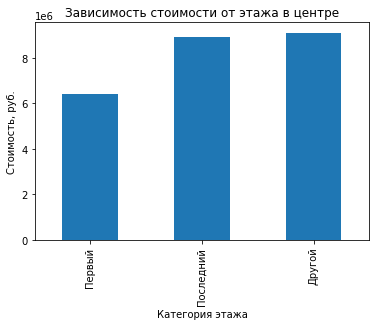

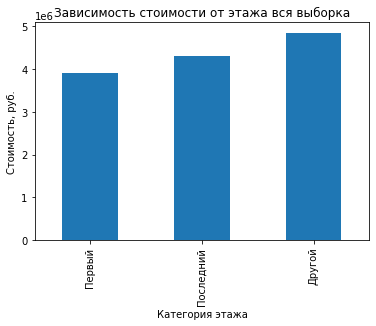

In [400]:
floor_category_center = center_data.groupby('floor_category')['last_price'].median().sort_values()
print(floor_category_center)
print(floor_category)
floor_category_center.plot(kind='bar', y='count')
plt.title("Зависимость стоимости от этажа в центре")
plt.xlabel("Категория этажа")
plt.ylabel("Стоимость, руб.")
plt.show()
floor_category.plot(kind='bar', y='count')
plt.title("Зависимость стоимости от этажа вся выборка")
plt.xlabel("Категория этажа")
plt.ylabel("Стоимость, руб.")
plt.show()

Первые этажи в центре заметно дешевле остальных. Потенциально может быть связано с большим потоком людей в центре, которые норовят заглянуть в окно.

   week_day_exposition  last_price  count
0                    0     9000000    589
1                    1     8700000    653
2                    2     8875000    670
3                    3     8700000    779
4                    4     8600000    655
5                    5     8372500    278
6                    6     8935000    230
    month_exposition  last_price  count
0                  1     9000000    245
1                  2     9000000    410
2                  3     8997500    406
3                  4     8500000    357
4                  5     8732500    230
5                  6     8525000    306
6                  7     9000000    299
7                  8     8800000    292
8                  9     9300000    353
9                 10     8500000    321
10                11     8990000    381
11                12     7758800    254
   year_exposition  last_price  count
0             2014    17000000     31
1             2015     9695000    326
2             2016     9325000

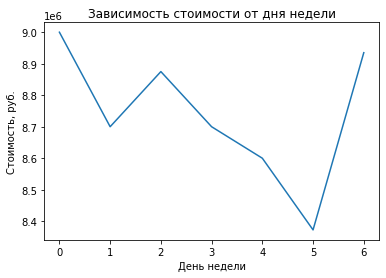

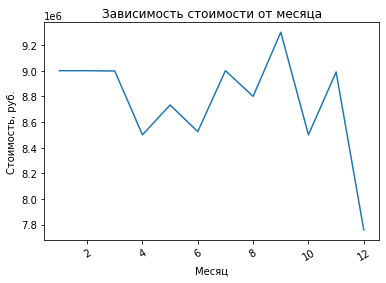

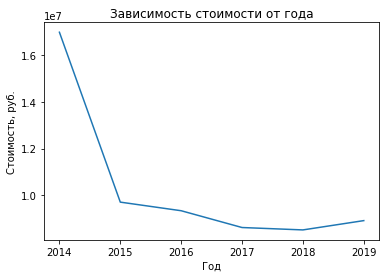

In [401]:
#Посстроим сводные таблицы
week_day_exposition = (center_data.
                   pivot_table(index='week_day_exposition', values='last_price', aggfunc=['median', 'count']).
                   reset_index())
month_exposition = (center_data.
                   pivot_table(index='month_exposition', values='last_price', aggfunc=['median', 'count']).
                   reset_index())
year_exposition = (center_data.
                   pivot_table(index='year_exposition', values='last_price', aggfunc=['median', 'count']).
                   reset_index())
week_day_exposition.columns = ['week_day_exposition', 'last_price', 'count']
month_exposition.columns = ['month_exposition', 'last_price', 'count']
year_exposition.columns = ['year_exposition', 'last_price', 'count']

#Выведем сводные 
print(week_day_exposition)
print(month_exposition)
print(year_exposition)

#Выведем гистограммы
# week_day_exposition.plot(x='week_day_exposition', y='last_price', kind='bar')
# plt.show()
# month_exposition.plot(x='month_exposition', y='last_price', kind='bar')
# plt.show()
# year_exposition.plot(x='year_exposition', y='last_price', kind='bar')
# plt.show()

sns.lineplot(data=week_day_exposition, x='week_day_exposition', y='last_price')
plt.title("Зависимость стоимости от дня недели")
plt.xlabel("День недели")
plt.ylabel("Стоимость, руб.")
plt.show()

plot = sns.lineplot(data=month_exposition, x='month_exposition', y='last_price')
plt.title("Зависимость стоимости от месяца")
plt.xlabel("Месяц")
plt.ylabel("Стоимость, руб.")
plt.setp(plot.get_xticklabels(), rotation=30)
plt.show()

sns.lineplot(data=year_exposition, x='year_exposition', y='last_price')
plt.title("Зависимость стоимости от года")
plt.xlabel("Год")
plt.ylabel("Стоимость, руб.")
plt.show()


## Вывод

Значения параметров в центре заметно отличаются от параметров выборки и области за центром. Большая площадь недвижимости, высота потолков и количество комнат могут быть обусловлены отсутствием новостроек-муравейников - в старых домах центра Питера все было с размахом. В новых домах центра Питера, наверное, тоже.

Корреляция стоимости квартир от разных факторов схожая, но в центре коэффициенты чуть ниже - может быть обусловлено самим хорошим расположанием. Основной вывод: самая сильная зависимость стоимости недвижимости - от её площади.

Квартиры на первых этажах в центре заметно дешевле. Это может быть связано с высокой проходимостью. А разрыв между последним \ другим по центру меньше, может, дело в красивых видах на город.

В отличии от общей выборки к месяцам с наименьшей стоимостью помимо июня добавляется ещё и декабрь. Наверное, в декабре также никто не хочет сильно усложнять продажу жилья, оставив сделку в старом году. По годам зависимость похожа на общую выборку.




## Общий вывод <a id="fourteenth_bullet"></a> 

##### Знакомство с данными и предобработка
Входные данные для анализа - архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.
Таблица размером 23699 на 22, с пропусками в 14 столбцах. Большое к-во пропусков было выявлено в полях, заполняемых автоматически, в частности, расстояния до центра, аэропорта, ближайшего парка и водоёма. 

Необходимо передать коллегам, собирающим выгрузку, что такое полезное поле, как расстояние до центра, не логирует многие соседние с Санкт-Петербургом населенные пункты. Для этого был собран список с уникальными названиями таких населенных пунктов - bag_report_list.

Пропуски в полях с жилой площадью и высотой потолков были заполнены характерными значением в зависимости от общей площади квартир после подтверждения наличия взаимосвязи. 

Также были удалены аномальные значения которые сильно выбиваются из выборки:
* квартиры площадью свыше 300 кв.метров и меньше 12 кв.метров
* квартиры с высотой потолков выше 5 и ниже 2.4 метров
* квартиры с количесвом комнат больше 14
* ценой больше 160 млн. и меньше 430 тыс.
* и с ценой за квадратный метр больше 400 тыс
* нулевой или слишком высокий этаж дома
* значения, где сумма площади кухни и жилой площади превышает общую
* значения, где отношение жилой площади к общей очень маленькое - меньше 0.34

Также все признаки площадей и обе цены были приведены к целочисленному типу данных.

Были посчитаны и добавлены в таблицу такие параметры как: цена квадратного метра; день, месяц, год публикации объявления;
категория этажей; соотношение жилой и общей площади, соотношение площади кухни и общей площади.

##### Исследовательский анализ
Построены гистограммы по следующим параметрам: площадь, цена, число комнат, высота потолков.
Как видно из графиков, больше всего продаются небольшие квартиры - одно- и двухкомнатные с площадью около 50 кв.м.
Это связано с тем, что квартиры такой площади в больших городах являются оптимальным решением при покупке, в первую очередь из-за стоимости, соответственно и продаваться они будут в большем количестве. 
Самая распространенная стоимость - от 4 до 5 млн. рублей, ну а высота потолков стандартная - 2,7 метра.

Применив метод describe, мы увидели, насколько отличается среднее значение от медианы. Это обусловлено большим хвостом выборки, который перетягивает на себя среднее. 
Четверть квартир были проданы за 1,5 месяца, половина за 95 дней, и большая часть в течение года.
За быстрые продажи можно считать те, что произошли до 45 дней - 25% выборки,
а долгие продажи все, что больше 231 дня - свыше 75% выборки.
Всё, что лежит за пределами верхнего уса ящика (1,5 межквартильных размаха), можем считать выбрасами.  
Таким образом, всё, что выходит за границу 510 дней - довольно большой срок продажи и скорее редкость.

Была проанализирована зафисимость стоимости квартиры от разных факторов. Больше всего стоимость квартиры зависит от её площади - коэффициент корреляции тут 0.78. Будь то центр города или пригород - люди, в первую очередь, платят за квадратные метры. Как следствие, имеется умеренная корреляция с количеством комнат, так как количество связано с площадью жилья. И самая слабая зависимость от удаленности от центра. 

Квартиры на первом и последнем этаже - более дешевые. Высокая проходимость и шум на первых этажах, а также нагрев помещения от крыши и потенциальное протекание оставляют своё влияние на стоимости квартир на этих этажах. Есть зависимость от месяца продажи - с наступлением тепла цены снижаются.

Ещё имеется зависимость от года размещения объявления - спад стоимости в 2015 и 2016 году. Основных гипотез 2 - маленькое к-во объявлений в выборке в сравнении с другими годами, а также падение рубля и введенные санкции, повлиявшие на экономику в целом и на рынок недвижимости в частности.

Был сформирован рейтинг с самым большим количеством объявлений. Ожидаемо - наибольшее к-во объявлений у Санкт-Петербурга - 15072, как и максимальная стоимость за квадратный метр. Далее по максимальной стоимости с большим отрывом идут - Пушкин и Кудрово.

Самые недорогие квартиры в рейтинге наибольшего к-ва объявлений, находятся в Шушары, Колпино и Выборге.

Построив график зависимости стоимости жилья от удаленности от центра, мы определили условные границы центральной зоны.

Значения параметров в центральной зоне заметно отличаются от параметров выборки. Большая площадь недвижимости, высота потолков и количество комнат может быть обусловлено отсутствием новостроек-муравейников - в старых домах центра Питера все было с размахом. В новых домах центра Питера, наверное, тоже.

Корреляция стоимости квартир от разных факторов схожая, но в центре коэффициенты чуть ниже - может быть обусловлено самим хорошим расположанием. Основной вывод: самая сильная зависимость стоимости недвижимости - от её площади.

Квартиры на первых этажах в центре заметно дешевле. Это может быть связано с высокой проходимостью. 

В отличии от общей выборки к месяцам с наименьшей стоимостью помимо июня добавляется ещё и декабрь. Наверное, в декабре также никто не хочет сильно усложнять продажу жилья, оставив сделку в старом году. По годам зависимость похожа на общую выборку.



